# Clothing image classification

## Fashion MNIST with Pytorch
Fashion MNIST dataset contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://i.postimg.cc/RVVCnL8w/mnist-fa-torch.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  
</table>


Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging between 0 and 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

<br>

# Neural Network with Pytorch (Binary Classification)

## Import Libraries

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

Using cuda device


## Load Dataset

4422102/4422102 [==============================] - 0s 0us/step
(28, 28)


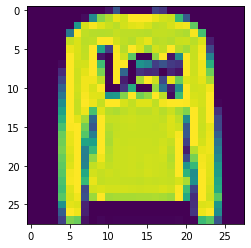

In [2]:
import torchvision

fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


print(X_test[1].shape)
plt.imshow(X_test[1])
plt.show()

## Data preprocessing

### Feature scaling

In [3]:
X_train = X_train/255.0
X_test = X_test/255.0

print(X_train.shape)
print(X_test.shape)
print(len(y_train))

(60000, 28, 28)
(10000, 28, 28)
60000


### Select two classes

#### Split the data into two classes

In [4]:
feature1 = 7
feature2 = 0

train_filter_arr_x = []
train_filter_arr_y = []
test_filter_arr_x = []
test_filter_arr_y = []

for i in range(0,len(y_train)):
    if y_train[i] == feature1:
      train_filter_arr_x.append(X_train[i])
      train_filter_arr_y.append(1)
    elif y_train[i] == feature2:
      train_filter_arr_x.append(X_train[i])
      train_filter_arr_y.append(0)

for i in range(0,len(y_test)):
    if y_test[i] == feature1:
      test_filter_arr_x.append(X_test[i])
      test_filter_arr_y.append(1)
    elif y_test[i] == feature2:
      test_filter_arr_x.append(X_test[i])
      test_filter_arr_y.append(0)



#### Class for the data set

In [5]:
class MyDataset(data.Dataset):
  def __init__(self,X,Y):
    self.X = X
    self.Y = Y
  def __len__(self):
    return len(self.Y)
  def __getitem__(self,index):
    X = self.X[index].float().reshape(-1)
    Y = self.Y[index].long()
    return X,Y

#### Converting the filtered data into torch, split the data into Dataloader

In [6]:
from torch.utils.data import DataLoader, RandomSampler

trainX = np.array(train_filter_arr_x)
trainY =  np.array(train_filter_arr_y)
testX = np.array(test_filter_arr_x)
testY =  np.array(test_filter_arr_y)



train_dataset = MyDataset(torch.from_numpy(trainX).float(),torch.from_numpy(trainY))
train_loader_args = dict(shuffle = True,batch_size = 256, num_workers = 0)
train_loader = DataLoader(train_dataset, **train_loader_args)



test_dataset = MyDataset(torch.from_numpy(testX).float(),torch.from_numpy(testY))
test_loader_args = dict(shuffle = True,batch_size = 256, num_workers = 0)
test_loader = DataLoader(test_dataset, **test_loader_args)

### Build the network layers

In [7]:
from torch import nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
  def __init__(self,layer_list):
      super(NeuralNetwork,self).__init__()
      layers = []
      self.layer_list = layer_list
      for i in range(len(layer_list)-2):
          layers.append(nn.Linear(layer_list[i],layer_list[i+1]))
          layers.append(nn.ReLU())
      layers.append(nn.Linear(layer_list[-2],layer_list[-1]))
      self.net = nn.Sequential(*layers)
  

  def forward(self, x):
    return self.net(x)

  def predict_bin(self, x_input):
      preds = []
      ready_input = torch.from_numpy(x_input).float().to(device)
      model = self
      for i in range(0,len(ready_input)):
        prediction = model(ready_input[i].reshape(-1)).item()
        if( prediction < 0):
          prediction = 0
        else:
          prediction = 1
        preds.append(prediction)
      return preds

  def predict(self, x_input):
      preds = []
      ready_input = torch.from_numpy(x_input).float().to(device)
      model = self
      for i in range(0,len(ready_input)):
        preds.append(model(ready_input[i].reshape(-1)).argmax().item())

      return preds

In [8]:
model = NeuralNetwork([784,10,1]).to(device)

print(model)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


### Build the Optimizer

In [9]:
from torch import optim
optimizer = optim.SGD(model.parameters(), lr= 0.01)

### Loss Function

In [10]:
loss = nn.BCEWithLogitsLoss()

### Training

##### Train helper functions

In [11]:
import time 

def train_epoch_bin(model,train_loader,criterion,optimizer):
    model.train()
    model.to(device)
    running_loss = 0.0
    correct_values = 0.0
    for batch_idx,(data,target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        outputs = model(data)
        outputs = outputs.reshape(-1) 
        current_loss = criterion(outputs,target.float())
        running_loss += current_loss.item()
        
        current_loss.backward()
        optimizer.step()
        predicted = outputs
        predicted[predicted<0] = 0
        predicted[predicted>0] = 1
        correct_values += (predicted == target).sum().item()

    running_loss /= len(train_loader)
    correct_values = correct_values/(len(train_loader.dataset.Y))*100
    print("Train Loss is ",running_loss)
    print("Train acc is ",(correct_values),'%')
    return running_loss,correct_values

def train_epoch_multi(model,train_loader,criterion,optimizer):
    model.train()
    model.to(device)
    running_loss = 0.0
    correct_values = 0.0
    start_time = time.time()
    for batch_idx,(data,target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        
        outputs = model(data)
        loss = criterion(outputs,target)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        _,predicted = torch.max(outputs.data,1)
        correct_values += (predicted==target).sum().item()  
    end_time = time.time()
    
    running_loss /= len(train_loader)
    correct_values = correct_values/(len(train_loader.dataset.Y))*100
    print("Train Loss is ",running_loss, " and time is ",end_time-start_time,'s')
    print("Train acc is ",(correct_values),'%')
    return running_loss,correct_values    


#### Test functions

In [12]:

def test_model_bin(model,test_loader,criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)
        running_loss = 0.0
        total_predictions = 0
        correct_predictions = 0
        for batch_idx,(data,target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)  
            outputs = outputs.reshape(-1)
            predicted = outputs
            predicted[predicted<0] = 0
            predicted[predicted>0] = 1
            total_predictions += target.size(0) 
            correct_predictions += (predicted==target).sum().item()
            current_loss = criterion(outputs, target.float()).detach()
            running_loss += current_loss.item()
            
        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Test Loss ',running_loss)
        print('Test Acc ', acc,'%')
        return running_loss,acc

def test_model_multi(model,test_loader,criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)
        running_loss = 0.0
        total_predictions = 0
        correct_predictions = 0
        for batch_idx,(data,target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)           
            _,predicted = torch.max(outputs.data,1)
            total_predictions += target.size(0)
            correct_predictions += (predicted==target).sum().item()       
            loss = criterion(outputs,target).detach()
            running_loss += loss.item()
        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Test Loss ',running_loss)
        print('Test Acc ', acc,'%')
        return running_loss,acc

#### Train the model and evaluate the model.

In [13]:
numner_of_epochs = 15

eval_losses=[]
eval_accu=[]

for epoch in range(numner_of_epochs):
  train_loss,train_acc = train_epoch_bin(model,train_loader,loss,optimizer)
  eval_losses.append(train_loss)
  eval_accu.append(train_acc)


Train Loss is  0.446231576990574
Train acc is  91.11666666666667 %
Train Loss is  0.19250898158296625
Train acc is  99.69166666666666 %
Train Loss is  0.10818328296250486
Train acc is  99.75833333333334 %
Train Loss is  0.07271225829707816
Train acc is  99.725 %
Train Loss is  0.05463216691575152
Train acc is  99.75833333333334 %
Train Loss is  0.043961664146565375
Train acc is  99.78333333333333 %
Train Loss is  0.037016641229708144
Train acc is  99.78333333333333 %
Train Loss is  0.03212238816504783
Train acc is  99.78333333333333 %
Train Loss is  0.028536589578428168
Train acc is  99.78333333333333 %
Train Loss is  0.025778593772903403
Train acc is  99.79166666666667 %
Train Loss is  0.023581544175109964
Train acc is  99.8 %
Train Loss is  0.02180411904416186
Train acc is  99.8 %
Train Loss is  0.020334741932914614
Train acc is  99.80833333333334 %
Train Loss is  0.01908936264350059
Train acc is  99.81666666666666 %
Train Loss is  0.01802224852144718
Train acc is  99.81666666666666 

### Save Trained model (weights)

In [14]:
# SAVE THE TRAINED MODEL
PATH = "BinaryClassification.pt"

# Save
torch.save(model.state_dict(), PATH)


### Loss and Accuracy Visualization
Show  on plot the lose during training

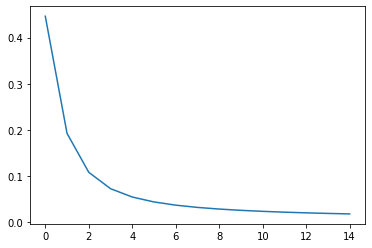

In [15]:
import matplotlib.pyplot as plt
plt.plot(eval_losses)

Show  on plot the accuracy during training

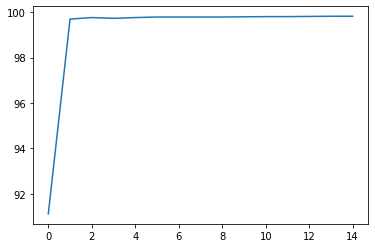

In [16]:
plt.plot(eval_accu)

### Test

In [17]:
from sklearn.metrics import accuracy_score
y_pred = model.predict_bin(testX)



### Model Evaluation

In [18]:
print("Accuracy:", accuracy_score(testY,y_pred))

Accuracy: 0.9985


#### Confusion matrix

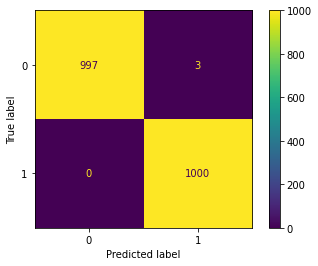

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

cm = confusion_matrix(testY, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

#### Classification report

In [20]:
target_names = ['0','7'] 
print(classification_report(test_filter_arr_y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           7       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



---
<br>


# Neural Network with Pytorch (Multiclass Classification)

## Import Libraries

In [21]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Dataset

(28, 28)


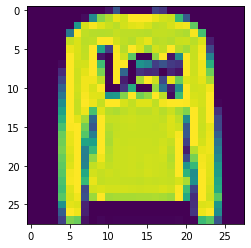

In [22]:
fashion_mnist = keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_test[1].shape)
plt.imshow(X_test[1])
plt.show()

## Data preprocessing

### Normalize The Data - Feature scaling

In [23]:
X_train = X_train/255.0
X_test = X_test/255.0

### Split to validation group

In [24]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

### Prepare the data

In [25]:
train_dataset = MyDataset(torch.from_numpy(train_x).float(),torch.from_numpy(train_y))
train_loader_args = dict(shuffle = True,batch_size = 256, num_workers = 0)
train_loader = DataLoader(train_dataset, **train_loader_args)

val_dataset = MyDataset(torch.from_numpy(val_x).float(),torch.from_numpy(val_y))
val_loader_args = dict(shuffle = True,batch_size = 256, num_workers = 0)
val_loader = DataLoader(val_dataset, **val_loader_args)

test_dataset = MyDataset(torch.from_numpy(X_test).float(),torch.from_numpy(y_test))
test_loader_args = dict(shuffle = True,batch_size = 256, num_workers = 0)
test_loader = DataLoader(test_dataset, **test_loader_args)

<ipython-input-25-b8a2e5a1a24f>:9: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  test_dataset = MyDataset(torch.from_numpy(X_test).float(),torch.from_numpy(y_test))


### Build the network layers

## Models

### Base Model

In [26]:
baseModel = NeuralNetwork([784,256,10]).to(device)

print(baseModel)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


### Loss func

In [27]:
loss = nn.CrossEntropyLoss()

### Optimizer

In [28]:
from torch import optim
optimizer = optim.SGD(baseModel.parameters(), lr= 0.01)

### Training

In [29]:
numner_of_epochs = 15

train_eval_losses=[]
train_eval_accu=[]
val_eval_losses=[]
val_eval_accu=[]

for epoch in range(numner_of_epochs):
  multi_train_loss, multi_train_acc = train_epoch_multi(baseModel,train_loader,loss,optimizer)
  train_eval_losses.append(multi_train_loss)
  train_eval_accu.append(multi_train_acc)
  val_loss,val_acc = test_model_multi(baseModel,val_loader,loss)
  val_eval_losses.append(val_loss)
  val_eval_accu.append(val_acc)

Train Loss is  1.8787850148298524  and time is  0.8645343780517578 s
Train acc is  49.388888888888886 %
Test Loss  1.4683414616827237
Test Acc  63.64666666666666 %
Train Loss is  1.2329048839482395  and time is  0.8424906730651855 s
Train acc is  65.93111111111111 %
Test Loss  1.0566035872798856
Test Acc  67.22666666666667 %
Train Loss is  0.9677659625356848  and time is  0.8499698638916016 s
Train acc is  68.79111111111112 %
Test Loss  0.8941108008562508
Test Acc  69.83333333333334 %
Train Loss is  0.8487093807621435  and time is  1.0087406635284424 s
Train acc is  71.34888888888888 %
Test Loss  0.8081613506300974
Test Acc  72.38 %
Train Loss is  0.7797169864855029  and time is  0.8711552619934082 s
Train acc is  73.69555555555556 %
Test Loss  0.7538871037758003
Test Acc  74.80666666666667 %
Train Loss is  0.7318069582635706  and time is  0.8371944427490234 s
Train acc is  75.42222222222222 %
Test Loss  0.7140245225469944
Test Acc  76.12666666666667 %
Train Loss is  0.6955091279338707

### Draw graph funtion

In [30]:
def draw_graph(train,val,label):
  plt.plot(train,color='b',label='train',linestyle='--'),plt.plot(val,color='r',label='val')
  plt.xlabel('epochs')
  plt.ylabel(label)
  plt.legend()

### Model train/val losses

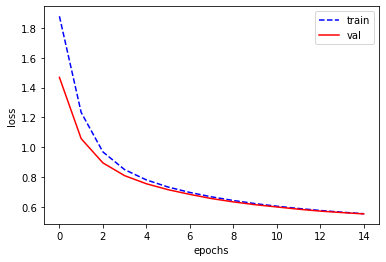

In [31]:
draw_graph(train_eval_losses,val_eval_losses,'loss')


### Model train/val accuracy

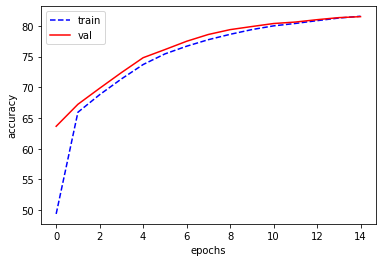

In [32]:
draw_graph(train_eval_accu,val_eval_accu,'accuracy')


### Test

In [33]:
from sklearn.metrics import accuracy_score

y_pred = baseModel.predict(X_test)


### Model Evaluation

In [34]:
print("Accuracy:", accuracy_score(test_dataset.Y.tolist(),y_pred))

Accuracy: 0.8043


In [35]:
target_names = [str(i) for i in range(10)]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78      1000
           1       0.96      0.94      0.95      1000
           2       0.72      0.64      0.68      1000
           3       0.79      0.85      0.82      1000
           4       0.66      0.80      0.72      1000
           5       0.94      0.82      0.87      1000
           6       0.57      0.48      0.52      1000
           7       0.84      0.89      0.86      1000
           8       0.91      0.94      0.92      1000
           9       0.86      0.93      0.90      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



### Experiment number 1

In [36]:
exModel01 = NeuralNetwork([784,256,128,10]).to(device)

print(exModel01)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Loss func

In [37]:
loss = nn.CrossEntropyLoss()

#### Train the model

In [38]:
numner_of_epochs = 15
optimizer = optim.SGD(exModel01.parameters(), lr= 0.01)

train_eval_losses=[]
train_eval_accu=[]
val_eval_losses=[]
val_eval_accu=[]

for epoch in range(numner_of_epochs):
  multi_train_loss, multi_train_acc = train_epoch_multi(exModel01,train_loader,loss,optimizer)
  train_eval_losses.append(multi_train_loss)
  train_eval_accu.append(multi_train_acc)
  val_loss,val_acc = test_model_multi(exModel01,val_loader,loss)
  val_eval_losses.append(val_loss)
  val_eval_accu.append(val_acc)

Train Loss is  2.1822118962352928  and time is  0.8865315914154053 s
Train acc is  34.82666666666667 %
Test Loss  2.009564795736539
Test Acc  56.54666666666667 %
Train Loss is  1.716660842976787  and time is  0.8803050518035889 s
Train acc is  58.9 %
Test Loss  1.424493531049308
Test Acc  60.85333333333334 %
Train Loss is  1.2479980005459352  and time is  0.8720700740814209 s
Train acc is  62.67777777777778 %
Test Loss  1.099589056887869
Test Acc  62.906666666666666 %
Train Loss is  1.0163029066540978  and time is  0.9069418907165527 s
Train acc is  65.57111111111111 %
Test Loss  0.9396120501776873
Test Acc  66.25333333333333 %
Train Loss is  0.8926648267290809  and time is  0.8888764381408691 s
Train acc is  67.92 %
Test Loss  0.8461726802890583
Test Acc  69.09333333333333 %
Train Loss is  0.8152020465243947  and time is  0.8756158351898193 s
Train acc is  69.92 %
Test Loss  0.7868633886515084
Test Acc  70.82000000000001 %
Train Loss is  0.7617734802717512  and time is  0.882266521453

### Model train/val losses

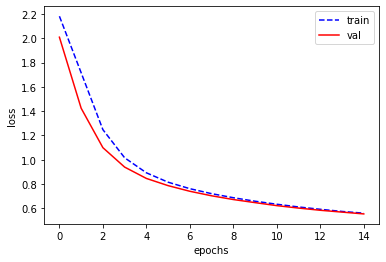

In [39]:
draw_graph(train_eval_losses,val_eval_losses,'loss')

### Model train/val accuracy

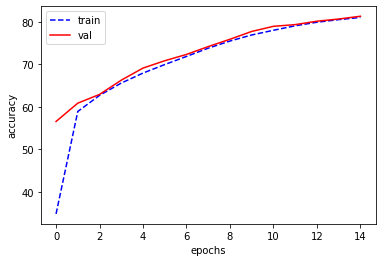

In [40]:
draw_graph(train_eval_accu,val_eval_accu,'accuracy')

### Test

In [41]:
y_pred = exModel01.predict(X_test)

### Model Evaluation

In [42]:
print("Accuracy:", accuracy_score(test_dataset.Y.tolist(),y_pred))

Accuracy: 0.8005


In [43]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1000
           1       0.97      0.93      0.95      1000
           2       0.69      0.68      0.69      1000
           3       0.81      0.83      0.82      1000
           4       0.67      0.74      0.70      1000
           5       0.93      0.86      0.89      1000
           6       0.53      0.42      0.47      1000
           7       0.87      0.86      0.87      1000
           8       0.91      0.94      0.92      1000
           9       0.86      0.94      0.90      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



### Experiment number 2

In [44]:
exModel02 = NeuralNetwork([784,256,10]).to(device)

optimizer = optim.Adam(exModel02.parameters())

print(exModel02)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


### Changing batch size

In [45]:
train_dataset = MyDataset(torch.from_numpy(train_x).float(),torch.from_numpy(train_y))
train_loader_args = dict(shuffle = True,batch_size = 64, num_workers = 0)
train_loader = DataLoader(train_dataset, **train_loader_args)

val_dataset = MyDataset(torch.from_numpy(val_x).float(),torch.from_numpy(val_y))
val_loader_args = dict(shuffle = True,batch_size = 64, num_workers = 0)
val_loader = DataLoader(val_dataset, **val_loader_args)

test_dataset = MyDataset(torch.from_numpy(X_test).float(),torch.from_numpy(y_test))
test_loader_args = dict(shuffle = True,batch_size = 64, num_workers = 0)
test_loader = DataLoader(test_dataset, **test_loader_args)

#### Train the model

In [46]:
numner_of_epochs = 8

train_eval_losses=[]
train_eval_accu=[]
val_eval_losses=[]
val_eval_accu=[]

for epoch in range(numner_of_epochs):
  multi_train_loss, multi_train_acc = train_epoch_multi(exModel02,train_loader,loss,optimizer)
  train_eval_losses.append(multi_train_loss)
  train_eval_accu.append(multi_train_acc)
  val_loss,val_acc = test_model_multi(exModel02,val_loader,loss)
  val_eval_losses.append(val_loss)
  val_eval_accu.append(val_acc)

Train Loss is  0.5501225563189522  and time is  1.7639446258544922 s
Train acc is  80.86666666666666 %
Test Loss  0.4362320141589388
Test Acc  84.84666666666666 %
Train Loss is  0.4028692315015095  and time is  1.749495506286621 s
Train acc is  85.49555555555555 %
Test Loss  0.3978784392488764
Test Acc  85.82 %
Train Loss is  0.3589482482057065  and time is  1.777146816253662 s
Train acc is  86.96444444444444 %
Test Loss  0.3623908963609249
Test Acc  86.80666666666667 %
Train Loss is  0.3305698408194902  and time is  1.740731954574585 s
Train acc is  87.76 %
Test Loss  0.37254386100363224
Test Acc  86.28666666666666 %
Train Loss is  0.30754308062817226  and time is  1.6864299774169922 s
Train acc is  88.69777777777777 %
Test Loss  0.3388768527736055
Test Acc  87.74 %
Train Loss is  0.2913681129311127  and time is  2.0923521518707275 s
Train acc is  89.29555555555555 %
Test Loss  0.3276096902312116
Test Acc  88.13333333333333 %
Train Loss is  0.27915278072892263  and time is  2.12796950

### Model train/val loss

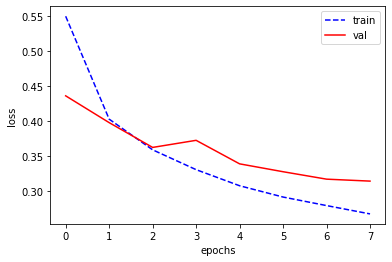

In [47]:
draw_graph(train_eval_losses,val_eval_losses,'loss')

### Model train/val accuracy

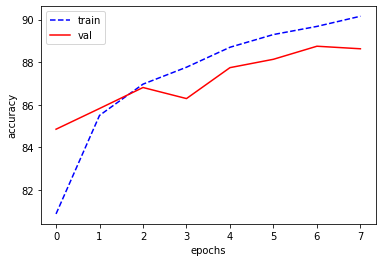

In [48]:
draw_graph(train_eval_accu,val_eval_accu,'accuracy')

### Test

In [49]:
y_pred = exModel02.predict(X_test)

### Save Base model (weights)

In [50]:
# SAVE THE TRAINED MODEL
PATH = "exModel02.pt"

# Save
torch.save(exModel02.state_dict(), PATH)


### Model Evaluation

In [51]:
print("Accuracy:", accuracy_score(test_dataset.Y.tolist(),y_pred))

Accuracy: 0.8777


In [52]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.76      0.78      1000
           3       0.91      0.86      0.88      1000
           4       0.78      0.81      0.79      1000
           5       0.96      0.96      0.96      1000
           6       0.68      0.69      0.69      1000
           7       0.94      0.95      0.95      1000
           8       0.98      0.96      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Test Environment

### Load trained model

In [53]:
model = NeuralNetwork([784,256,10]) 
model.load_state_dict(torch.load(PATH))
model.eval()

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

### Single prediction
Testing the best model, uploading the image using google colab.

In [54]:
from numpy import load as load_npy
from google.colab import files
uploaded = files.upload()

Saving Shirt_6.npy to Shirt_6.npy


In [55]:
np_image = np.load(list(uploaded.keys())[0])
normalize_image = np_image/255.0
prediction_input = np.array([normalize_image.reshape(-1)])
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.predict(prediction_input)

[6]